<a href="https://colab.research.google.com/github/MattiaGatto/Prediction_society/blob/main/prediction_society_value_close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modello che preveda i prezzi delle azioni di una azienda x giorni nel futuro in base al prezzo di chiusura corrente.

---
# Librerie necessarie all'utilizzo

In [1]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from joblib import dump, load 
from pathlib import Path
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 11.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
Mounted at /content/drive


## Riceverò la quotazione delle azioni della società "Apple Inc." utilizzando il ticker di borsa delle società (AAPL) da 20 anni fa ad oggi.



In [2]:
INTERVALLO_ANNI=20

today=datetime.today().strftime('%Y-%m-%d')
start=str( datetime(int(today[:4])-INTERVALLO_ANNI,int(today[5:7]),int(today[8:])))[:10]
print("from",start,"to",today)

society='META'

#Ricevi la quotazione di borsa 
df = web.DataReader(society, data_source='yahoo', start=start, end=today) 

#stampa il numero di righe e colonne nel set di dati.
print(df.shape)

#stampa le quotazioni
df

from 2002-09-02 to 2022-09-02
(2591, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999
...,...,...,...,...,...,...
2022-08-29,163.050003,159.009995,160.660004,159.169998,20052700,159.169998
2022-08-30,161.660004,155.910004,160.350006,157.160004,19567900,157.160004
2022-08-31,167.839996,162.139999,167.070007,162.929993,40953000,162.929993


---
# DATA VISUALIZATION

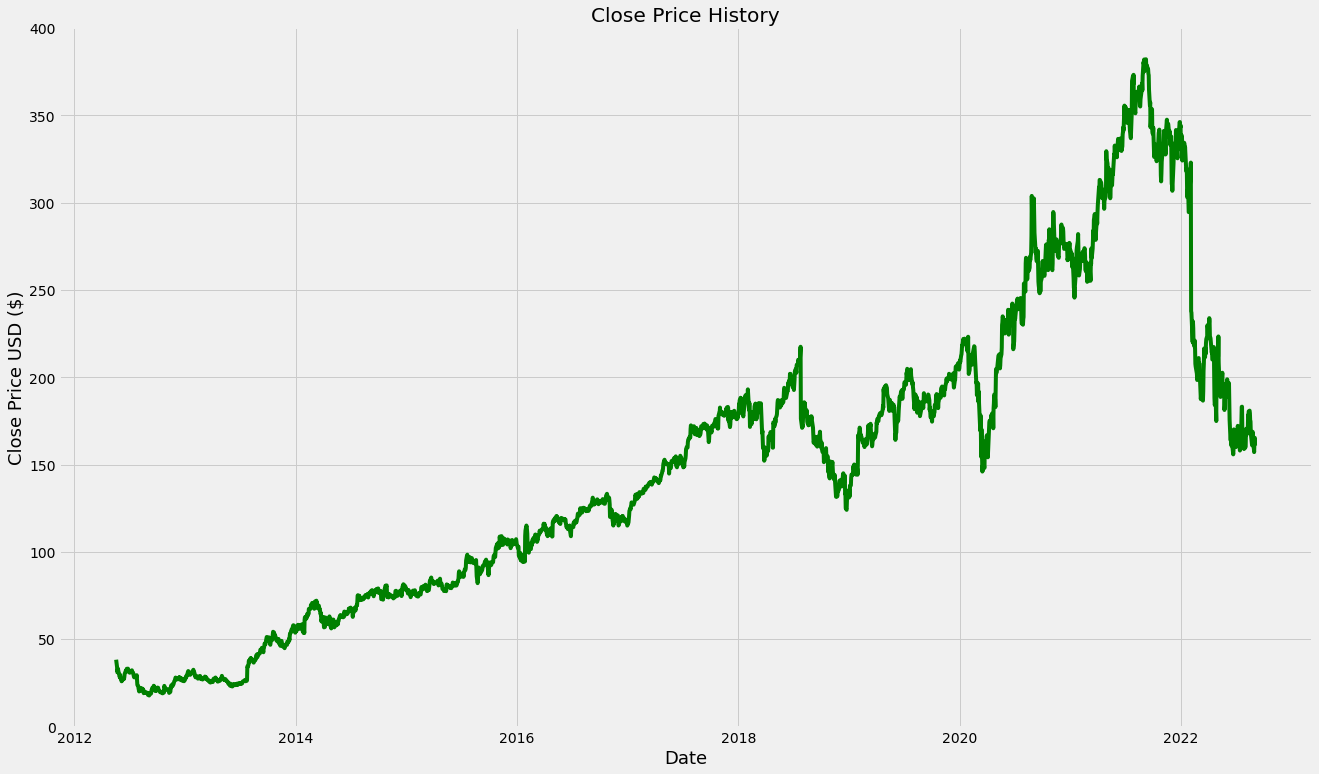

In [3]:
#Visualizza la cronologia del prezzo di chiusura
plt.figure(figsize=(20,12))
plt.title('Close Price History')
plt.plot(df['Close'], 'g')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

---
# DATA PREPARATION

## Il seguente grafico mostra la cronologia dei prezzi delle azioni in fase di chiusura di Apple Inc nell'intervallo di tempo.

## Task:
*   Verrà definito un nuovo dataFrame con solo le informazioni relative al prezzo di chiusura.
*   Il set di dati sarà convertilo in un array.
*   Verrà creata una variabile per memorizzare la lunghezza del dataset di addestramento che contenga circa l'80% dei dati, in modo da poter utilizzare il restante 20% per il dataset di test.







In [4]:
#nuova dataframe solo con le chiusure
data = df.filter(['Close'])
#Convertiamolo in un numpy array
dataset = data.values
training_data_len = math.ceil( len(dataset) *.8) # 80% dei dati

#Scala tutti i dati in modo che siano valori compresi tra 0 e 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

Verrà creato un dataset di addestramento che contenga i valori del prezzo di chiusura degli ultimi Z giorni che si desidera utilizzare per prevedere il valore del prezzo di chiusura dal Z+1° in poi.

La prima colonna nel dataset 'x_train' conterrà i valori del dataset dall'indice 0 all'indice Z-1 (Z valori in totale) e la seconda colonna conterrà i valori del dataset dall'indice 1 all'indice Z (Z valori) e così via. 

Il dataset " y_train " conterrà il Z+1° valore situato all'indice Z per la sua prima colonna e il 62° valore situato all'indice 61 del dataset per il suo secondo valore e così via.


In [5]:
#Crea il set di dati per l'addestramento in scala
train_data = scaled_data[0:training_data_len  , : ]

#Intervallo di previsione
Z=60 #quasi 2 mesi nel futuro

#Dividi i dati nel x_train e  y_train
x_train=[]
y_train = []
for i in range(Z,len(train_data)):
 x_train.append(train_data[i-Z:i,0])
 y_train.append(train_data[i,0])

# Converti x_train e y_train in array
x_train, y_train = np.array(x_train), np.array(y_train)
print("x train shape :",x_train.shape,"\ny train shape :",y_train.shape)

x train shape : (2013, 60) 
y train shape : (2013,)


---
# MODEL TRAINING

In [6]:
#caricamento 
def load_model(model_path, model):
    model=load(model_path)
    return model

#salvataggio
def save_model(model,model_path):
    dump(model,model_path)
    return model
    
def verifica_esistenza_modello(file_name):
    esiste=False
    try:
        my_file = Path(file_name)
        if my_file.is_file():
          esiste=True
    except IOError:
        print("File not accessible")
    print("Il modello addestrato esiste?",esiste)
    return esiste

## Rimodellare i dati in modo tridimensionale nella forma :

1.   Numero di campioni 
2.   Numero di fasi temporali da prendere in considerazione
3.   numero di caratteristiche

Il modello LSTM si aspetta un set di dati tridimensionale.

In [7]:
# Reshape i dati nella forma accettata da LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print("x train shape :",x_train.shape)

x train shape : (2013, 60, 1)


## Costruisci il modello LSTM per avere :
1. Due strati LSTM con 50 neuroni;

2. Due strati densi di cui: 

  1. Uno con 25 neuroni;

  2. L'altro con 1 neurone di output, ai fini della predizione;

Compilare il modello utilizzando la funzione di perdita dell'errore quadratico medio (MSE) e l'ottimizzatore adam.

In [8]:
#Costruiamo il LSTM network model
def LSTM_network_model():
  model = Sequential()
  model.add(LSTM(units=32, return_sequences=True,input_shape=(x_train.shape[1],1)))
  model.add(LSTM(units=16, return_sequences=False))
  model.add(Dense(units=8))
  model.add(Dense(units=1))
  return model

model=LSTM_network_model()

#Compila il modello model.compile
model.compile(optimizer='adam', loss='mean_squared_error')

Addestra il modello utilizzando il dataset di addestramento. La dimensione del batch è il numero totale di esempi di addestramento presenti in un singolo batch ed epoch è il numero di iterazioni in cui un intero dataset viene passato avanti e indietro attraverso la rete neurale.

In [9]:
EPOCHS=10
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_"+society+"_"+str(INTERVALLO_ANNI)+"y_"+str(Z)+"d_pred_"+str(EPOCHS)+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_META_20y_60d_pred_10ep.model
Il modello addestrato esiste? True


In [10]:
if exist_model==False:
  model.fit(x_train, y_train, batch_size=1, epochs=EPOCHS,workers=-1)
  model=save_model(model,path_name)
else:
  model=load_model(path_name, model)

---
#TEST
Crea un set di dati di test.

In [11]:
#Dati di test
test_data = scaled_data[training_data_len - Z: , : ]
#Crea i set di dati x_test e y_test
x_test = []
y_test = dataset[training_data_len : , : ] 
#Recupera tutte le righe dall'indice len(training_dataset) al resto e tutte le colonne (in questo caso è solo la colonna "Close")
#per recuperare il 20% dei dati che c'eravamo tenuti per la fase di test
for i in range(Z,len(test_data)):
 x_test.append(test_data[i-Z:i,0])

In [12]:
# Converti x_test in un array numpy 
x_test = np.array(x_test)
#Reshape i dati nella forma accettata da LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

Ora ottieni i valori previsti dal modello utilizzando i dati del test.

In [13]:
#Otteniamo le predizioni del modello
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

* Ottieni l'errore quadratico medio (RMSE), che è una buona misura dell'accuratezza del modello.

* Un valore pari a 0 indica che i valori previsti dai modelli corrispondono perfettamente ai valori effettivi del set di dati del test.

* Più basso è il valore, migliori saranno le prestazioni del modello. Ma di solito è meglio usare anche altre metriche per avere davvero un'idea di come si sia comportato bene il modello.

In [14]:
# Calcola / Ottieni il valore di RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print(rmse)


11.190501608653364


# Tracciamo e visualizziamo i dati.
Il grafico che mostra i prezzi di formazione (training), effettivi (validi) e previsti (previsioni).

Mostra i prezzi validi e previsti.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


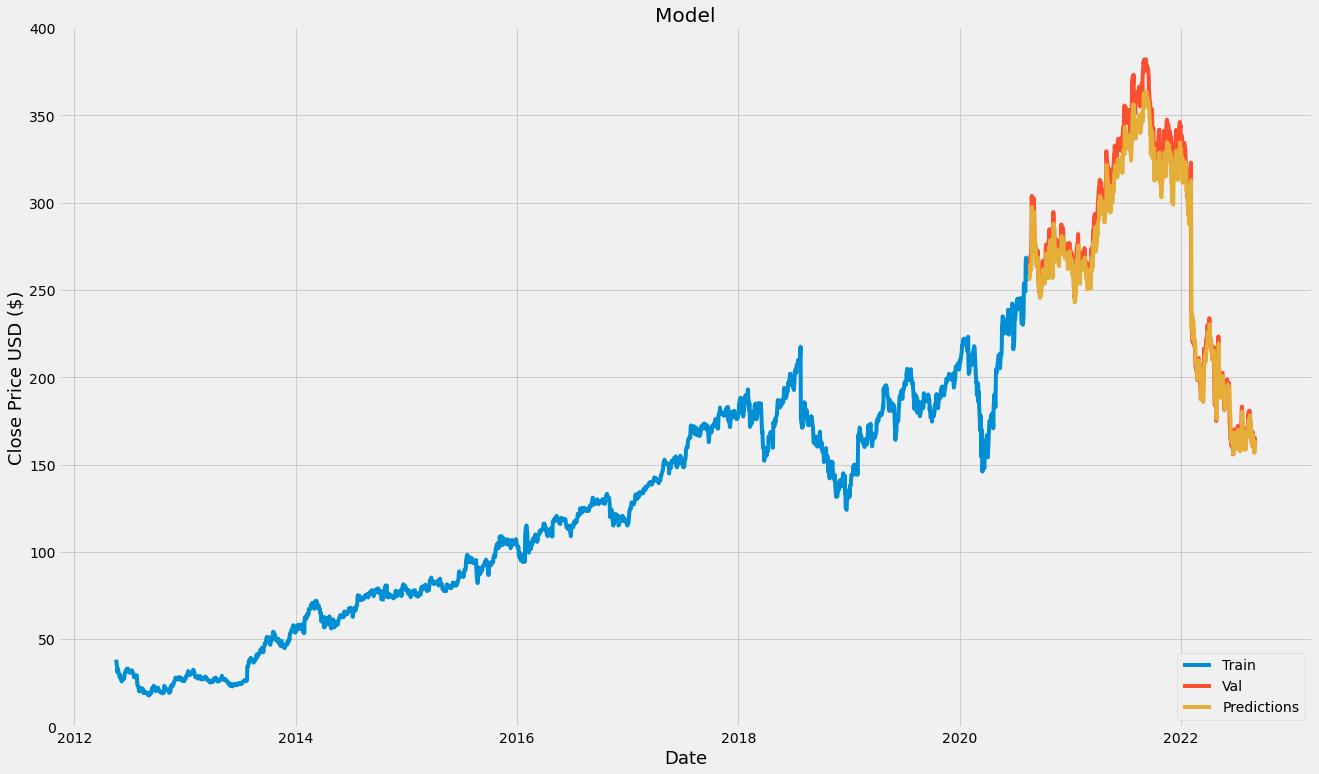

In [15]:
# Traccia / Crea i dati per il
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(20,12))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [16]:
# I valori del prezzo effettivo (close) e previsto (previsioni).
valid

,Close,Predictions
Date,,
2020-08-14,261.239990,256.498840
2020-08-17,261.160004,256.313324
2020-08-18,262.339996,256.278473
2020-08-19,262.589996,257.544556
2020-08-20,269.010010,257.791504
...,...,...
2022-08-29,159.169998,161.868317
2022-08-30,157.160004,158.757416
2022-08-31,162.929993,156.725281


---
#Prediction

Voglio testare ancora il modello e ottenere il valore del prezzo di chiusura previsto di Apple Inc. per il 2 settembre 2022 (2/09/2022).

1. Convertirò i dati in un array che contiene solo il prezzo di chiusura, quindi otterrò il prezzo di chiusura degli ultimi 60 giorni e ridimensionerò i dati in modo che siano valori compresi tra 0 e 1 inclusi.

2. Dopodiché creerò un elenco vuoto e vi aggiungerò il prezzo degli ultimi 60 giorni, quindi lo convertirò in un array numpy e lo rimodellerò in modo da poter inserire i dati nel modello.

3. Ultimo ma non meno importante, inserirò i dati nel modello e otterrò il prezzo previsto.

In [17]:
# Ottieni i dati
prediction_date='2022-09-02'
apple_quote = web.DataReader(society, data_source='yahoo', start=start, end=prediction_date)
#Crea un nuovo dataframe
new_df = apple_quote.filter(['Close'])
# Ottieni il prezzo di chiusura degli ultimi Z giorni 
last_Z_days = new_df[-Z:].values
#Scala i dati in modo che siano valori compresi tra 0 e 1
last_Z_days_scaled = scaler.transform(last_Z_days)
#Crea un elenco vuoto
X_test = []
#Appendi agli ultimi Z giorni
X_test.append(last_Z_days_scaled)
# Converti il ​​set di dati X_test in un array
X_test = np.array(X_test)
#ridimensioni i dati 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Ottieni il prezzo scalato previsto
pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform (pred_price)
print (pred_price)

[[160.21855]]


Ora vediamo qual era il prezzo effettivo per quel giorno.

In [18]:
apple_quote2 = web.DataReader(society, data_source='yahoo', start=prediction_date, end=prediction_date)
print(apple_quote2['Close'])

Date
2022-09-02    160.75
Name: Close, dtype: float64


In [20]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/project/prediction_society_value_close.ipynb 

[NbConvertApp] Converting notebook /content/drive/MyDrive/project/prediction_society_value_close.ipynb to html
[NbConvertApp] Writing 523822 bytes to /content/drive/MyDrive/project/prediction_society_value_close.html
